In [48]:
!pip install EMD-signal

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import pandas as pd

# Load the Excel file
file_path = 'superstore.xls'
superstore_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
superstore_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [50]:
# Calculate daily sales
daily_sales = superstore_data.groupby('Order Date')['Sales'].sum().reset_index()

# Display the first few rows of the daily sales dataframe
daily_sales.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [51]:
import plotly.express as px

# Create the plotly figure
fig = px.line(daily_sales, x='Order Date', y='Sales', title='Daily Sales Over Time', labels={'Order Date': 'Order Date', 'Sales': 'Sales'})

# Update layout for better readability
fig.update_layout(xaxis_title='Order Date', yaxis_title='Sales', xaxis=dict(tickangle=45))

# Display the plot
fig.show()

- The 'period' parameter in the seasonal_decompose function specifies the number of observations per cycle.
- In this case, 'period=365' indicates that the data has a yearly seasonality, assuming daily data.
- This means the function will look for patterns that repeat every 365 days.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_sales['Sales'], model='additive', period=365)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Original Series', 'Trend', 'Seasonal', 'Residual'])

# Add traces
fig.add_trace(go.Scatter(x=daily_sales['Order Date'], y=daily_sales['Sales'], mode='lines', name='Original Series'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_sales['Order Date'], y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=daily_sales['Order Date'], y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=daily_sales['Order Date'], y=residual, mode='lines', name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(height=800, title='Time Series Decomposition of Daily Sales', xaxis_title='Order Date', yaxis_title='Sales')
fig.update_xaxes(tickangle=45)

# Display the plot
fig.show()

In [29]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# augmented Dickey-Fuller test
adf_test = adfuller(daily_sales['Sales'].dropna())

# extract and display the test results
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output[f'Critical Value ({key})'] = value

# display the ADF test results
adf_output

# interpretation of the ADF test results
if adf_output['p-value'] < 0.05:
    interpretation = "The time series is stationary (reject the null hypothesis)."
else:
    interpretation = "The time series is not stationary (fail to reject the null hypothesis)."

interpretation

'The time series is stationary (reject the null hypothesis).'

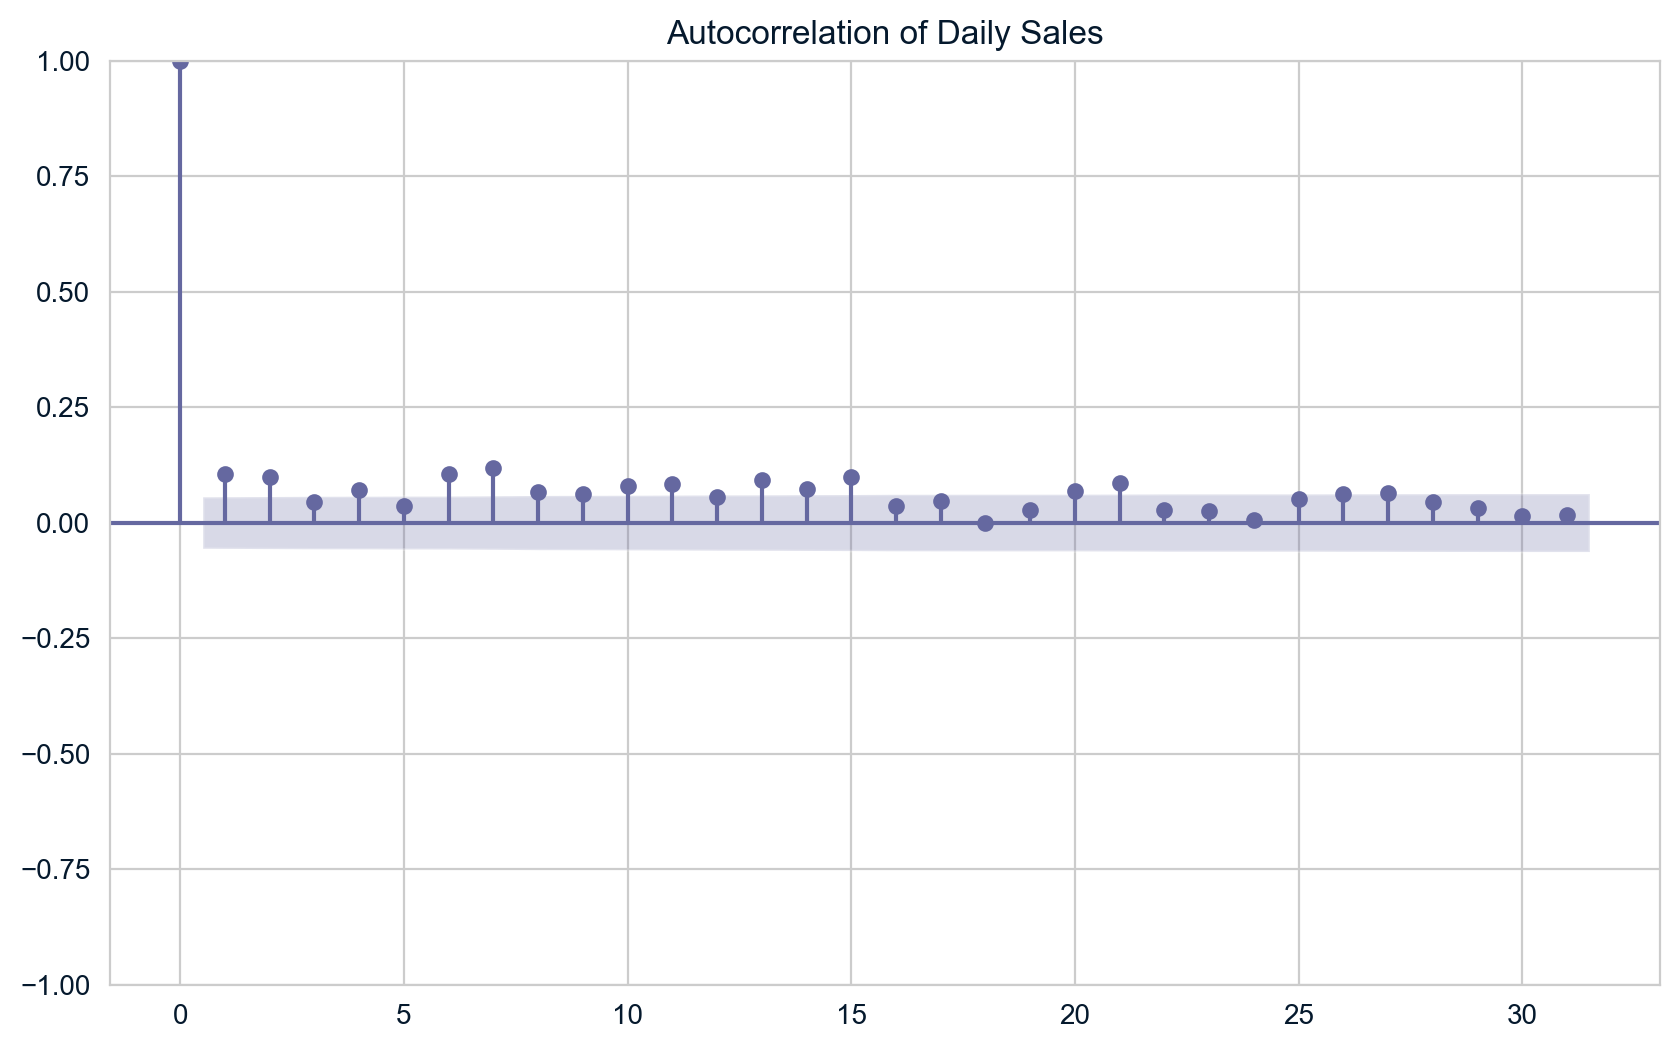

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

# visualize autocorrelation function for the 'Sales' column in the daily_sales dataframe
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(daily_sales['Sales'].dropna(), ax=ax)
plt.title('Autocorrelation of Daily Sales')
plt.show()

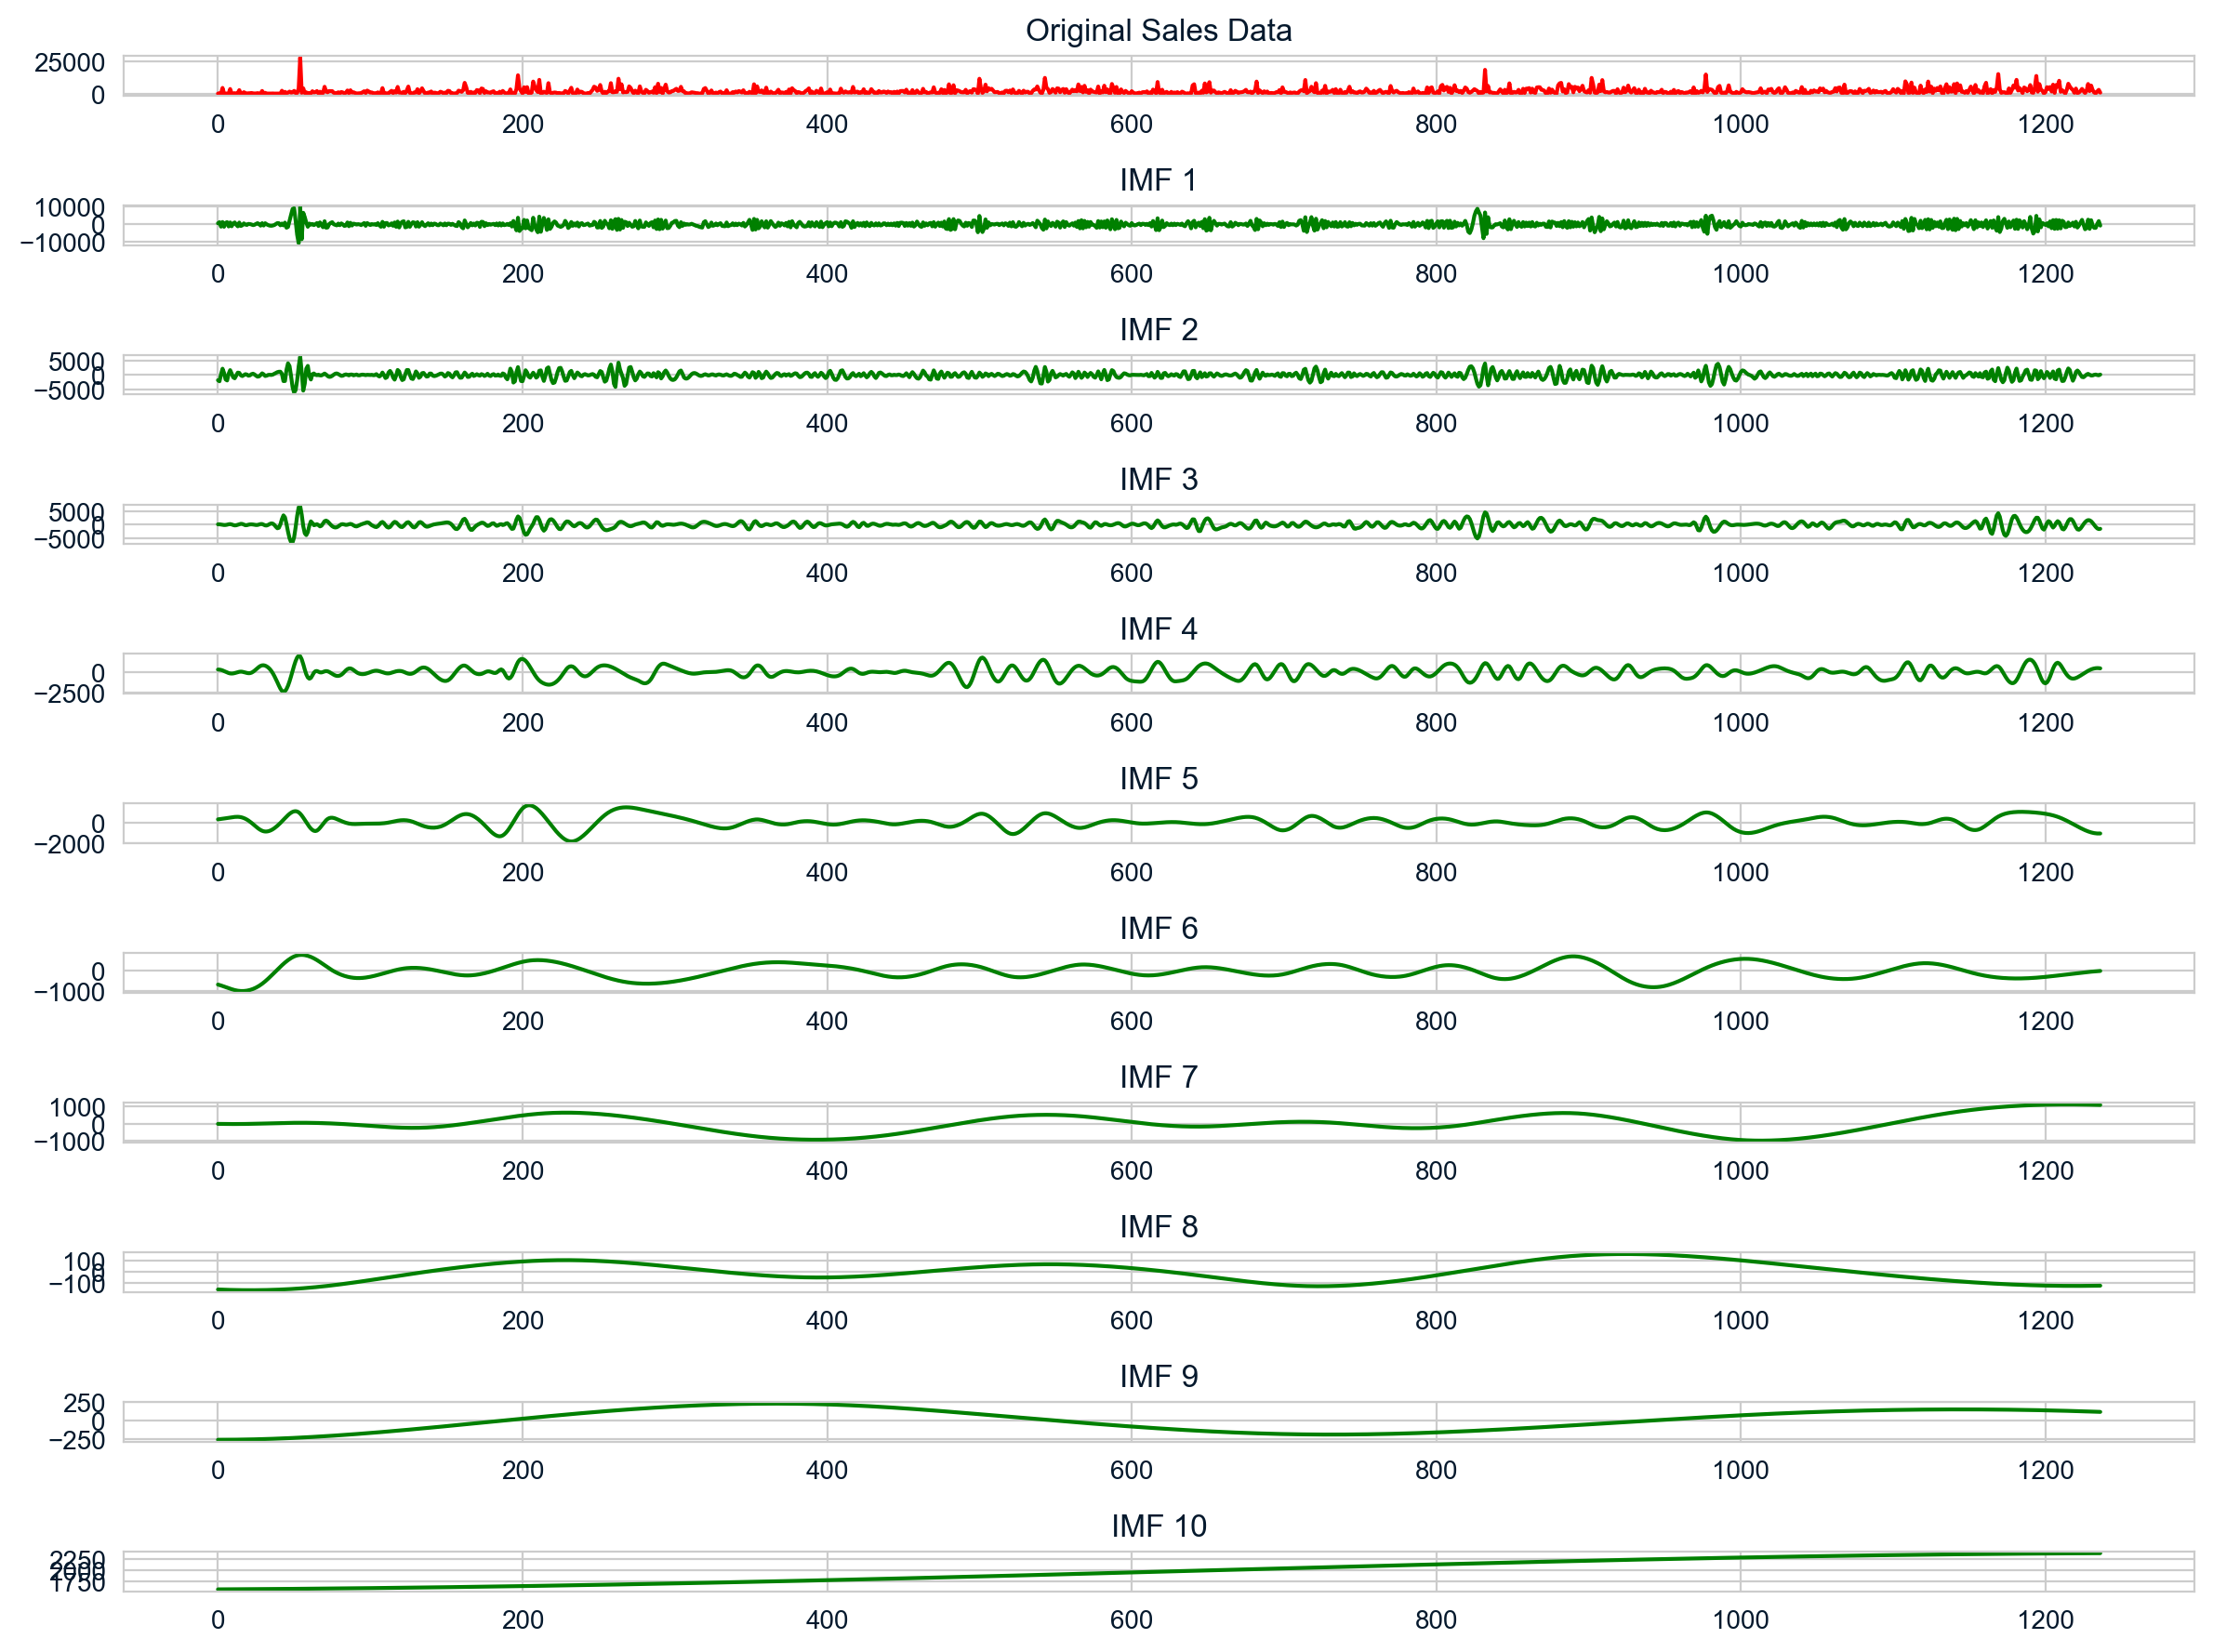

In [37]:
from PyEMD import EMD
import numpy as np
import matplotlib.pyplot as plt

# get 'Sales' data and convert it to a numpy array
sales_data = daily_sales['Sales'].dropna().values

# Empirical Mode Decomposition
emd = EMD()
IMFs = emd(sales_data)

# plot resulting Intrinsic Mode Functions (IMFs)
fig, axes = plt.subplots(len(IMFs) + 1, 1, figsize=(12, 9))


axes[0].plot(sales_data, 'r')
axes[0].set_title("Original Sales Data")

# plot each IMF
for i, imf in enumerate(IMFs):
    axes[i + 1].plot(imf, 'g')
    axes[i + 1].set_title(f"IMF {i + 1}")

plt.tight_layout()
plt.show()

# Noise 

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Smoothen the daily_sales using a rolling mean
daily_sales['Smoothed_Sales'] = daily_sales['Sales'].rolling(window=7, center=True).mean()

# Drop NaN values resulting from the rolling mean
smoothed_sales = daily_sales['Smoothed_Sales'].dropna()

# Perform seasonal decomposition
result = seasonal_decompose(smoothed_sales, model='additive', period=365)

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

# Observed
fig.add_trace(go.Scatter(x=smoothed_sales.index, y=result.observed, mode='lines', name='Observed'), row=1, col=1)

# Trend
fig.add_trace(go.Scatter(x=smoothed_sales.index, y=result.trend, mode='lines', name='Trend'), row=2, col=1)

# Seasonal
fig.add_trace(go.Scatter(x=smoothed_sales.index, y=result.seasonal, mode='lines', name='Seasonal'), row=3, col=1)

# Residual
fig.add_trace(go.Scatter(x=smoothed_sales.index, y=result.resid, mode='lines', name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(height=800, width=1000, title_text="Seasonal Decomposition of Smoothed Daily Sales")
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.show()